# Example code for the SEM analysis module
The goal of the analysis module is to determine quality parameters of lines created using lithography processes without using digital processing, as this causes image information loss/deformation. For this reason we use the following global workflow:

* Load the image and convert to grayscale
* Determine estimated object positions in the image (seperate_opjects function)
* Get the cropped images for each found object (get_objects function)
* Determine the object profiles from the image (extract_profiles function)
* Determine the roughness using PSD analysis (calculate_profile_psd function)

For more information on how each step is performed see the docstrings of each function.

In [7]:
# Import some dependencies
from pytools_lithography.analysis import (
    separate_objects,
    get_object,
    mark_objects,
    extract_profiles,
    calculate_profile_psd
)
import os
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

# Only used for getting the test image
from tests.utils import get_test_img_path

In [8]:
# Define some global variables
SHOW_STEPS = True  # If true most processes will show the image modifications they are making

Load the images. This notebook expects the images to be in the same folder as this file, so make sure to make the path relative to here or change the loading code

In [9]:
# Define the filenames
lines_filename = "test_analysis_lines.jpg"
size_bar_filename = "test_analysis_size_bar.jpg"

In [10]:
# Create the full paths
divider = "/" if os.name == "posix" else "\\"
lines_image_path = get_test_img_path(lines_filename)
size_bar_image_path = get_test_img_path(size_bar_filename)

# Check if the files exist
if not os.path.exists(lines_image_path):
    print(f"Error: {lines_image_path} does not exist.")
    exit(1)

if not os.path.exists(size_bar_image_path):
    print(f"Error: {size_bar_image_path} does not exist.")
    exit(1)

# Load the images
lines_image = cv2.imread(lines_image_path)
size_bar_image = cv2.imread(size_bar_image_path)

# Convert the images to grayscale
lines_image_gray = cv2.cvtColor(lines_image, cv2.COLOR_BGR2GRAY)
size_bar_image_gray = cv2.cvtColor(size_bar_image, cv2.COLOR_BGR2GRAY)

To make analysis of images with multiple objects possible we need to reduce the original image to multiple images with only one object. These separate objects are then analyzed individually after which the results can be combined. The objects are found by creating masks using basic thresholding and connected component analysis. After the mask is found it is dilated (enlarged) to make sure the whole object is in the mask and then the mask is cropped out of the original image.

A mask is a binary image (image consisting of only 0's and 1's) where the image contains a 1 in the positions where the object was detected.

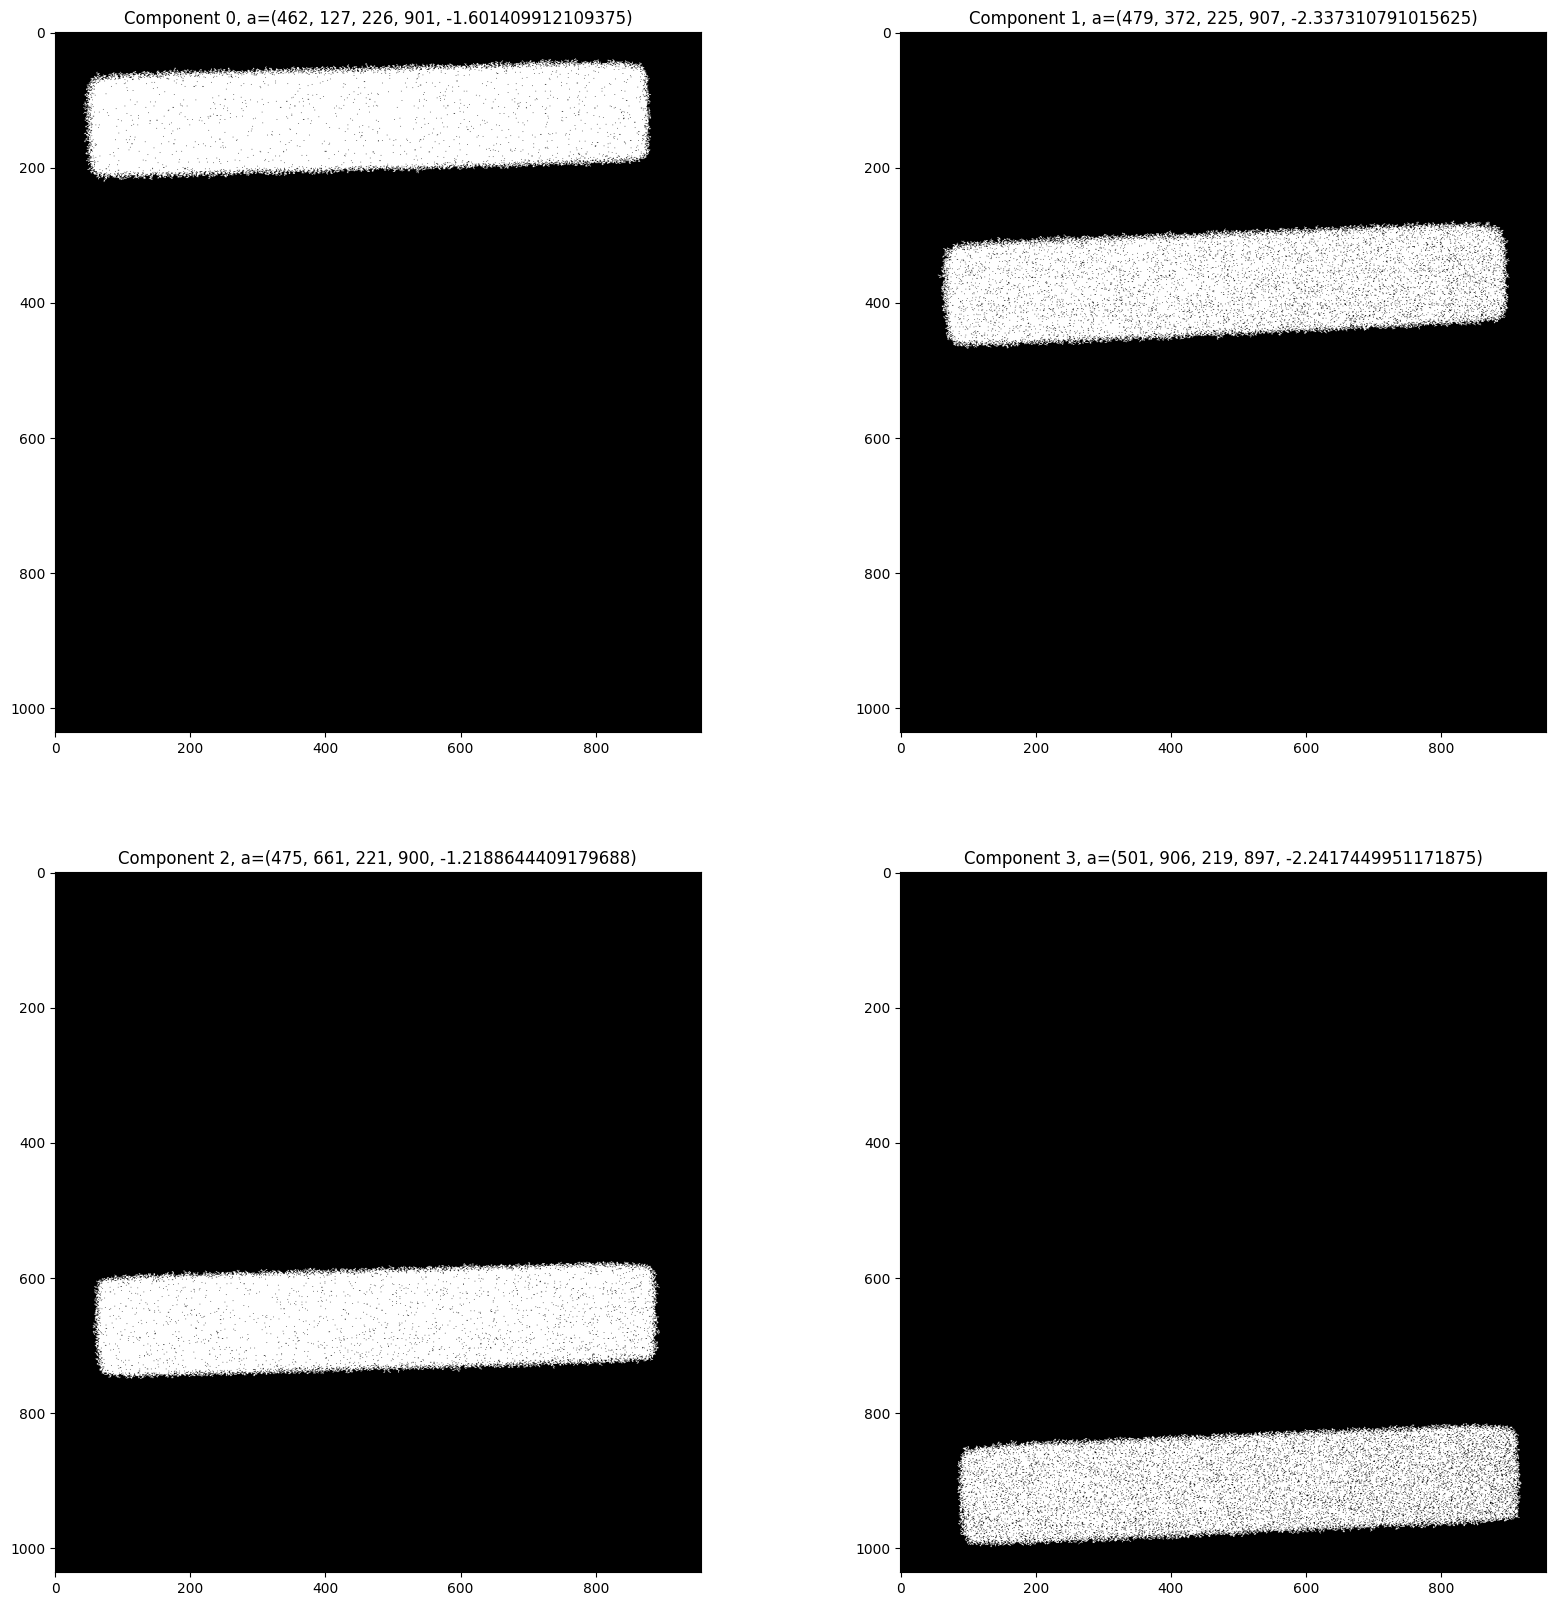

In [11]:
# Get the objects masks and their angles
masks, angles = separate_objects(lines_image_gray, show_steps=SHOW_STEPS)

If you are analyzing a lot of lines it might be a good idea to use the mark_objects function to mark the objects you want to use to keep track of them.

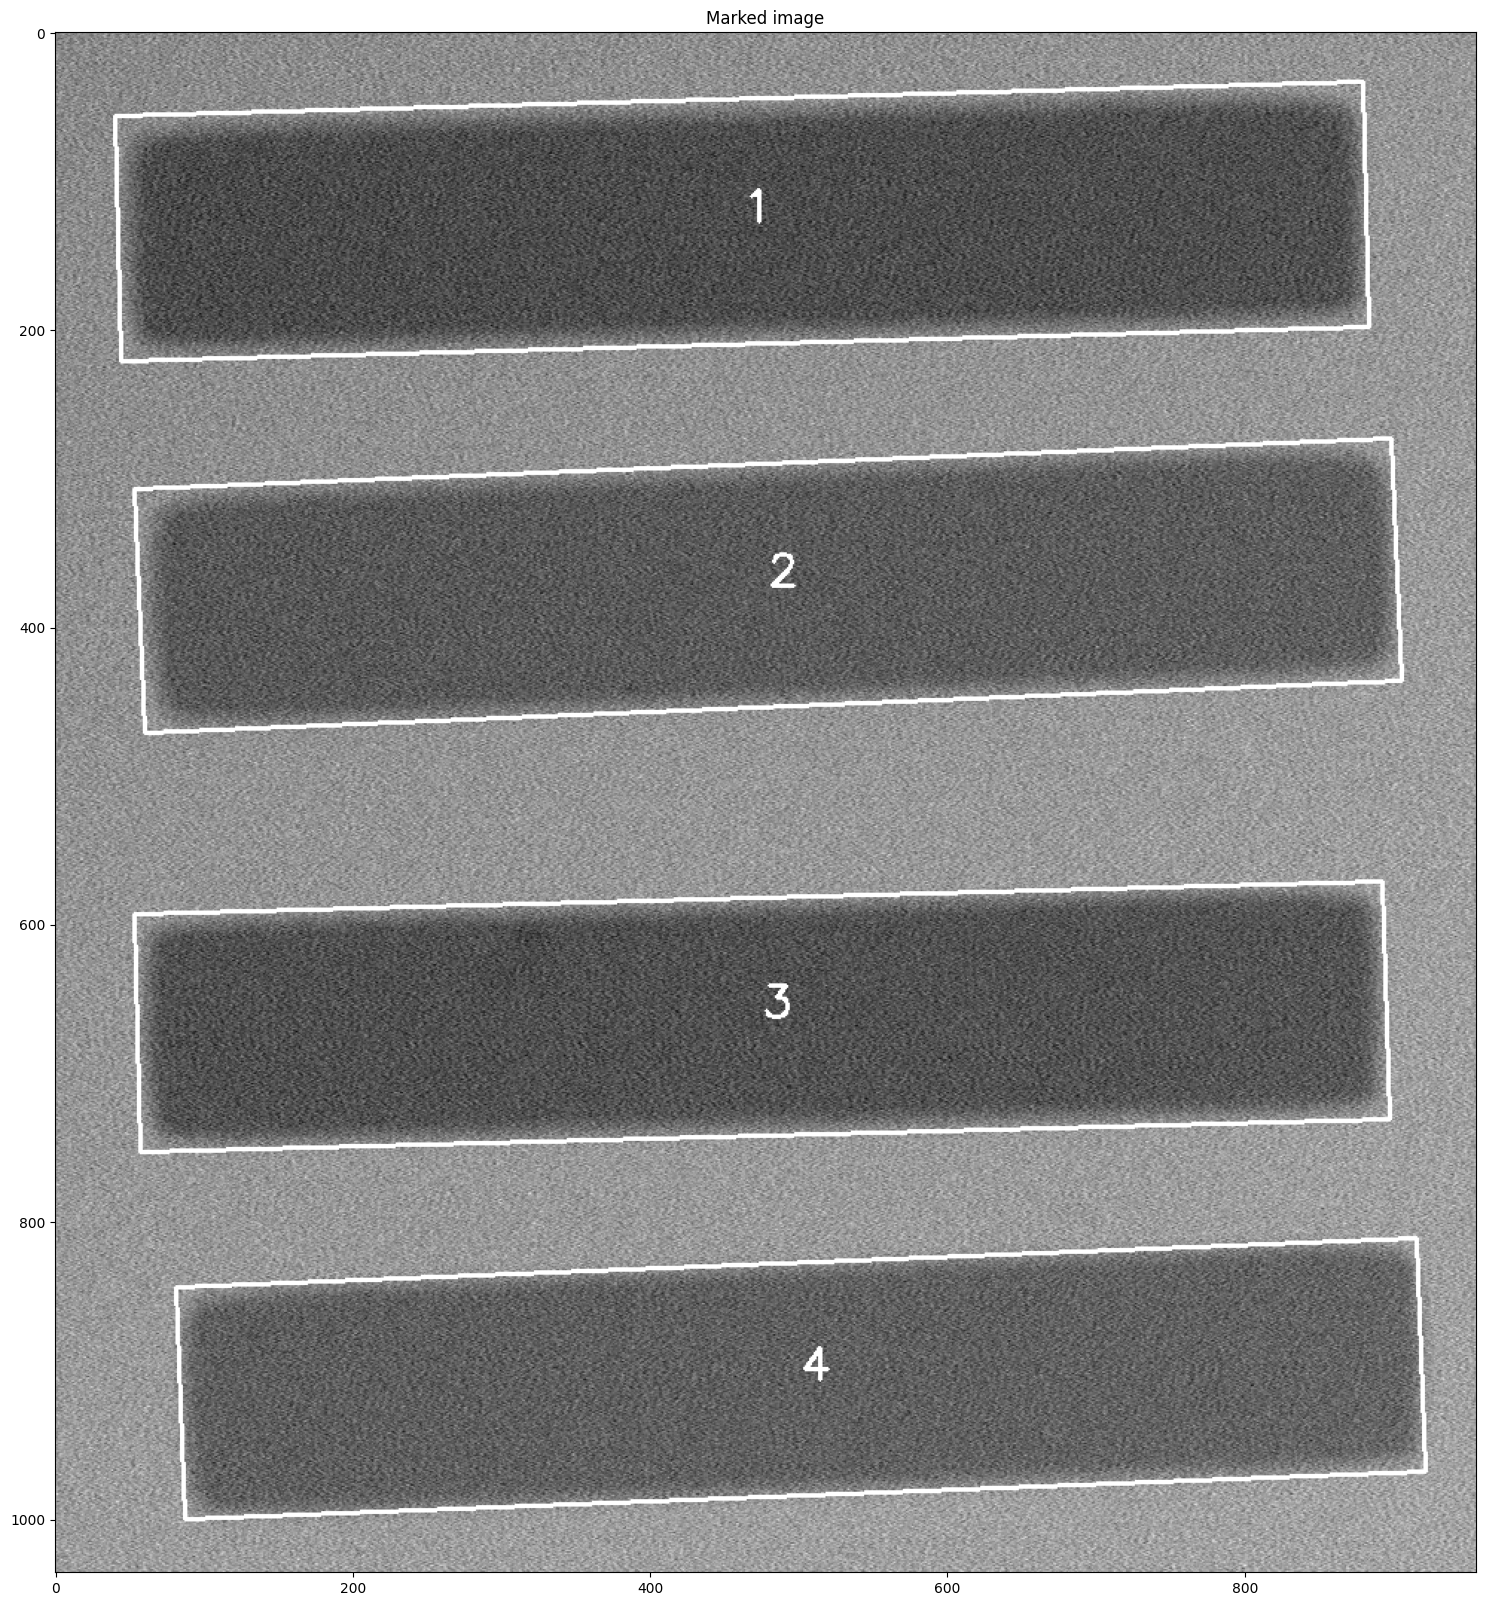

In [12]:
# Mark the objects
marked_image, ids = mark_objects(lines_image_gray, masks, start_id=0, show_steps=SHOW_STEPS)

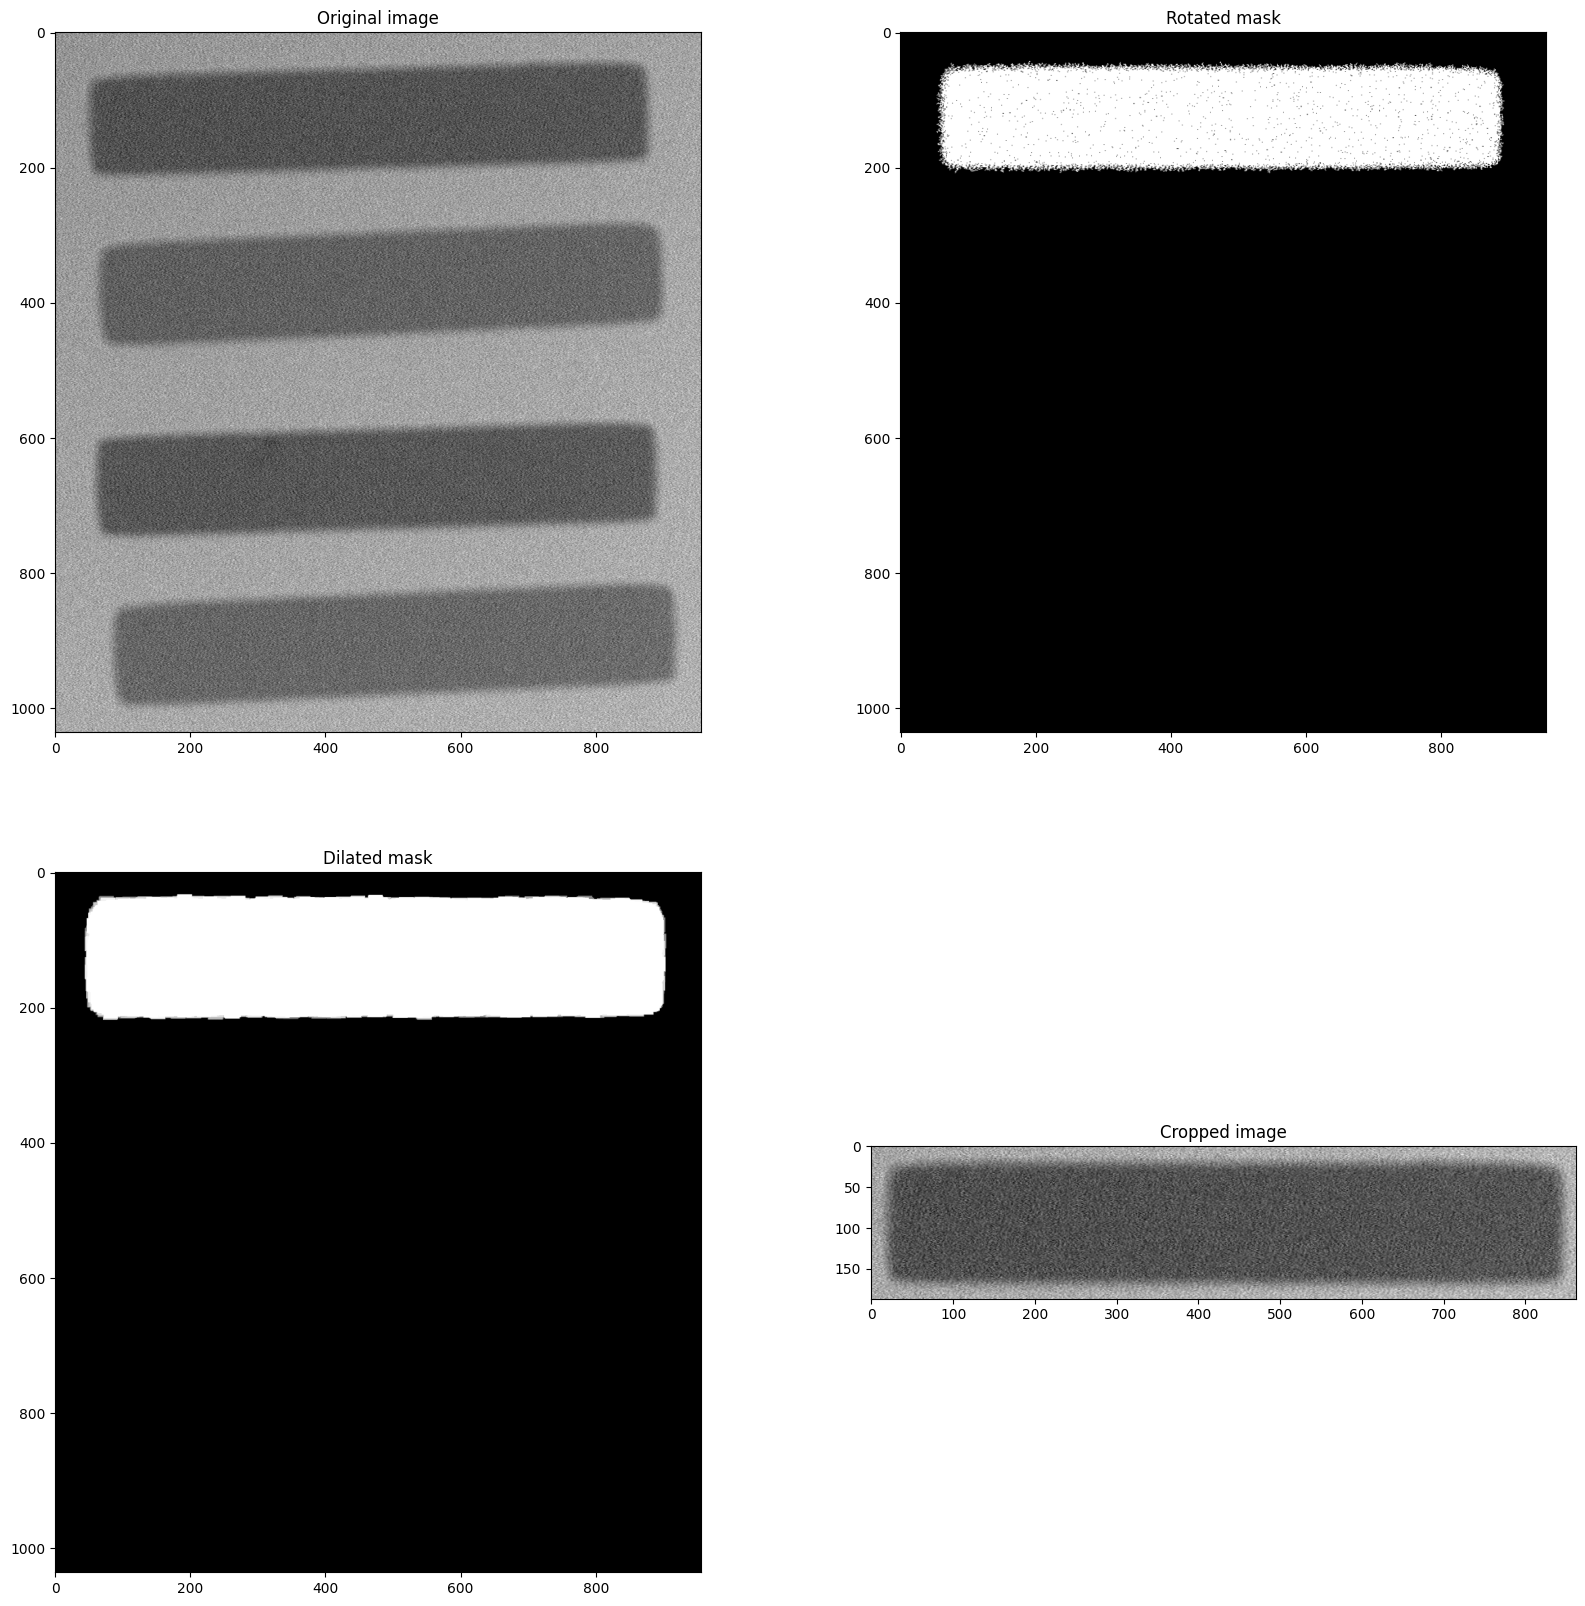

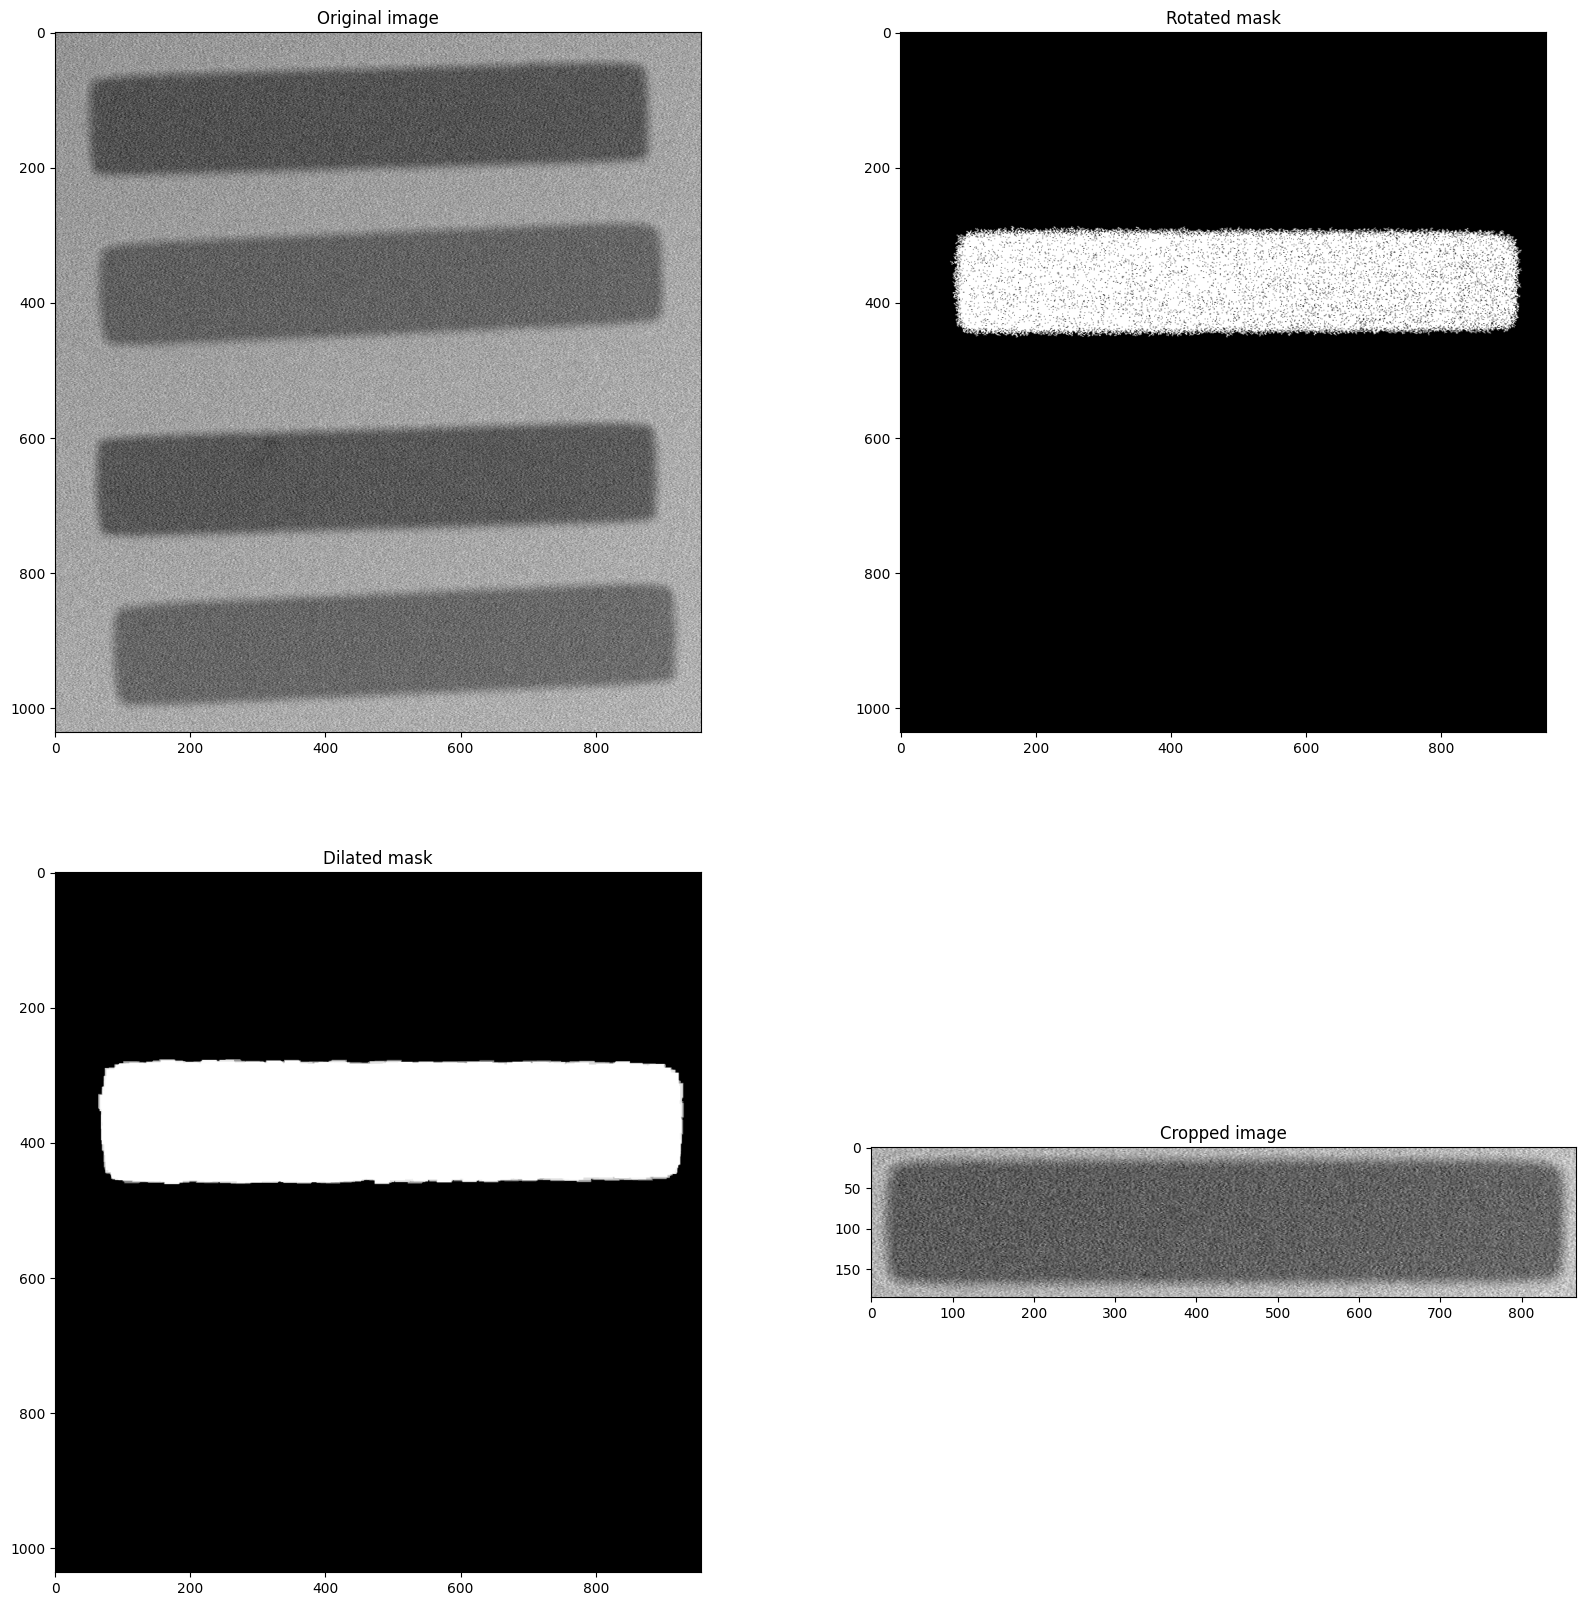

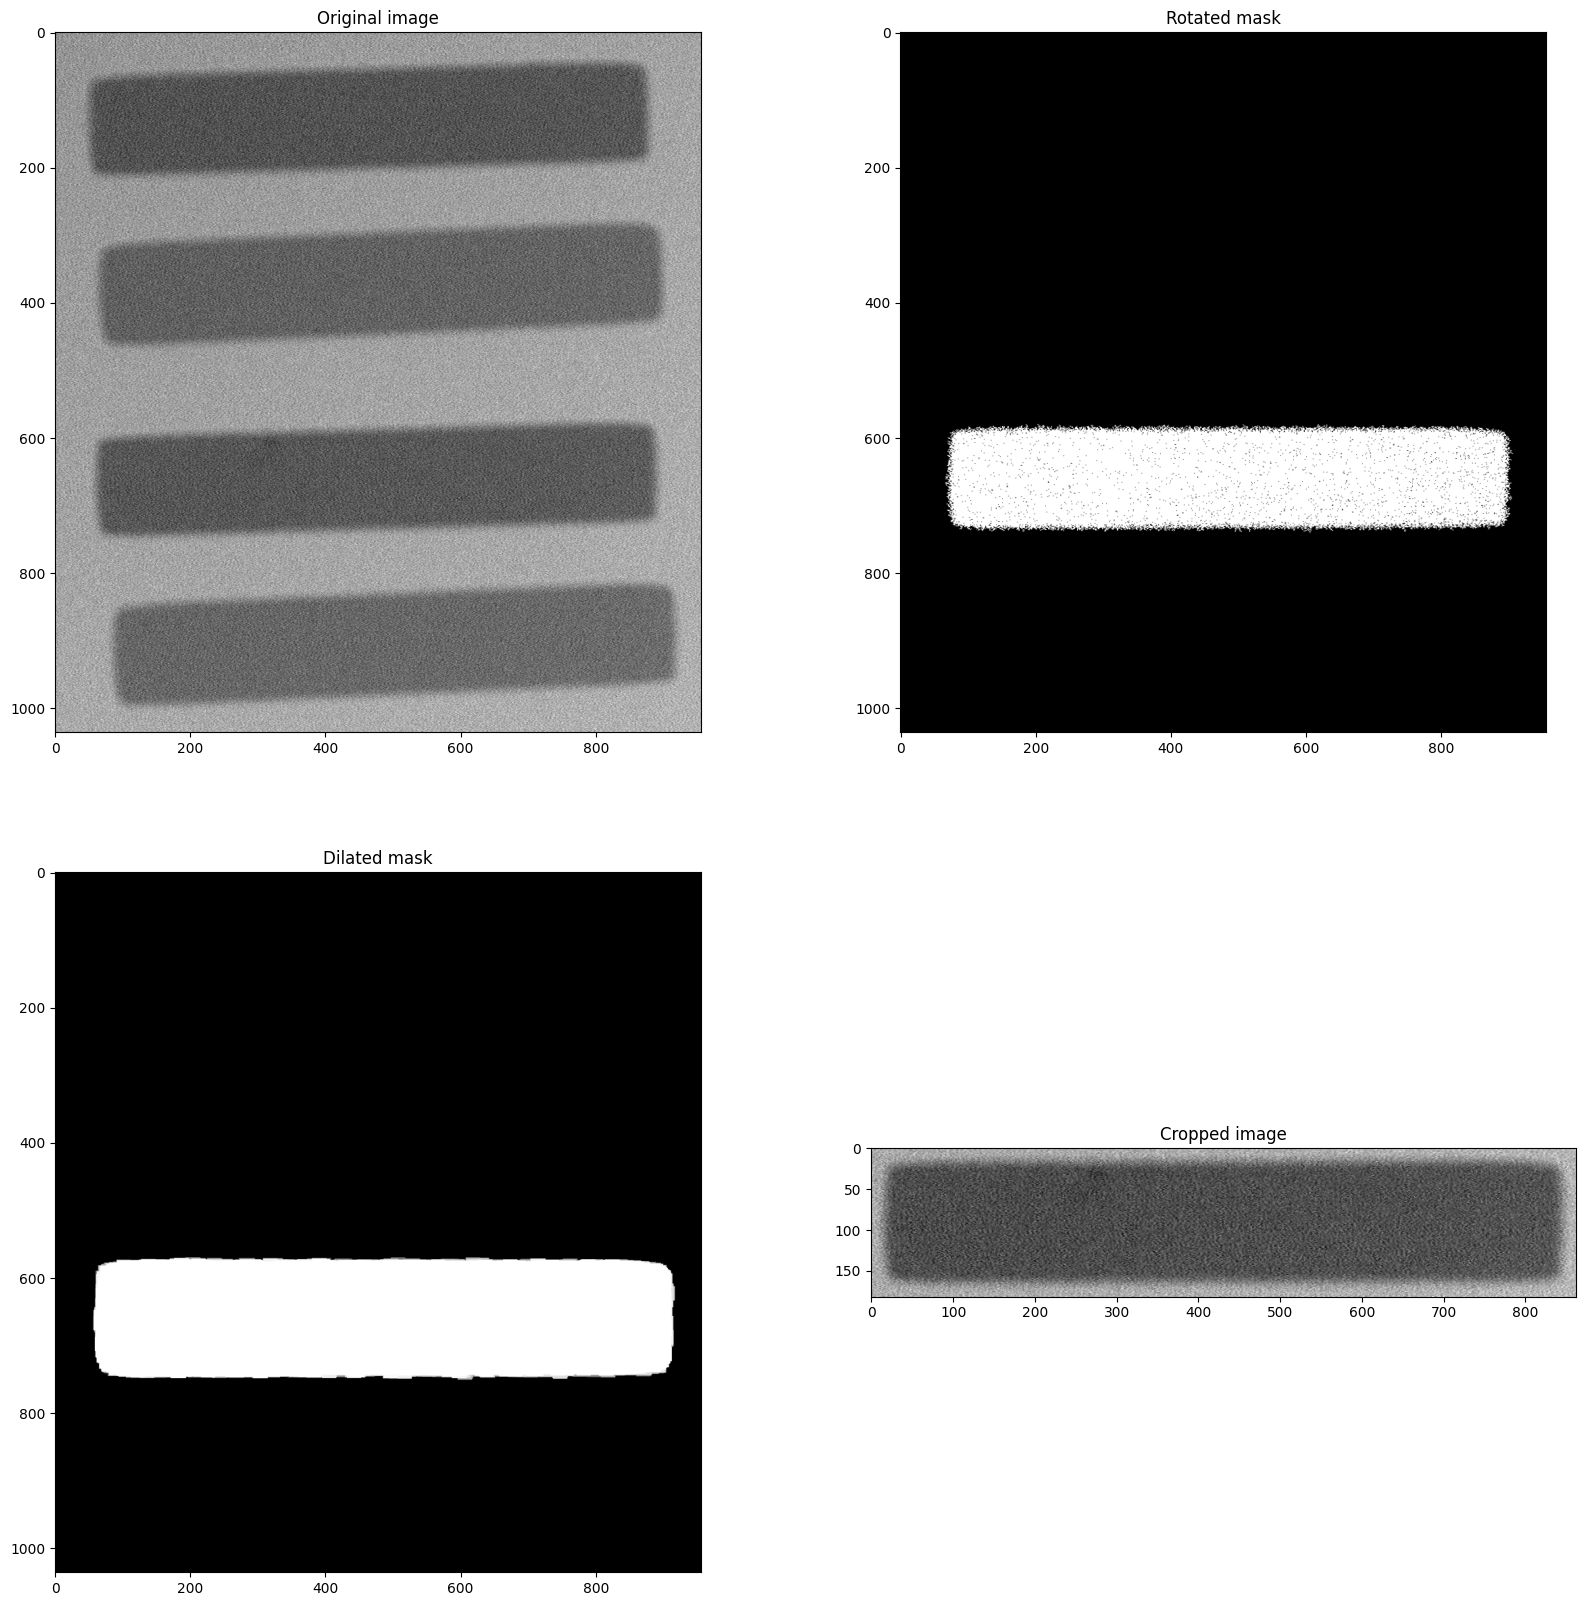

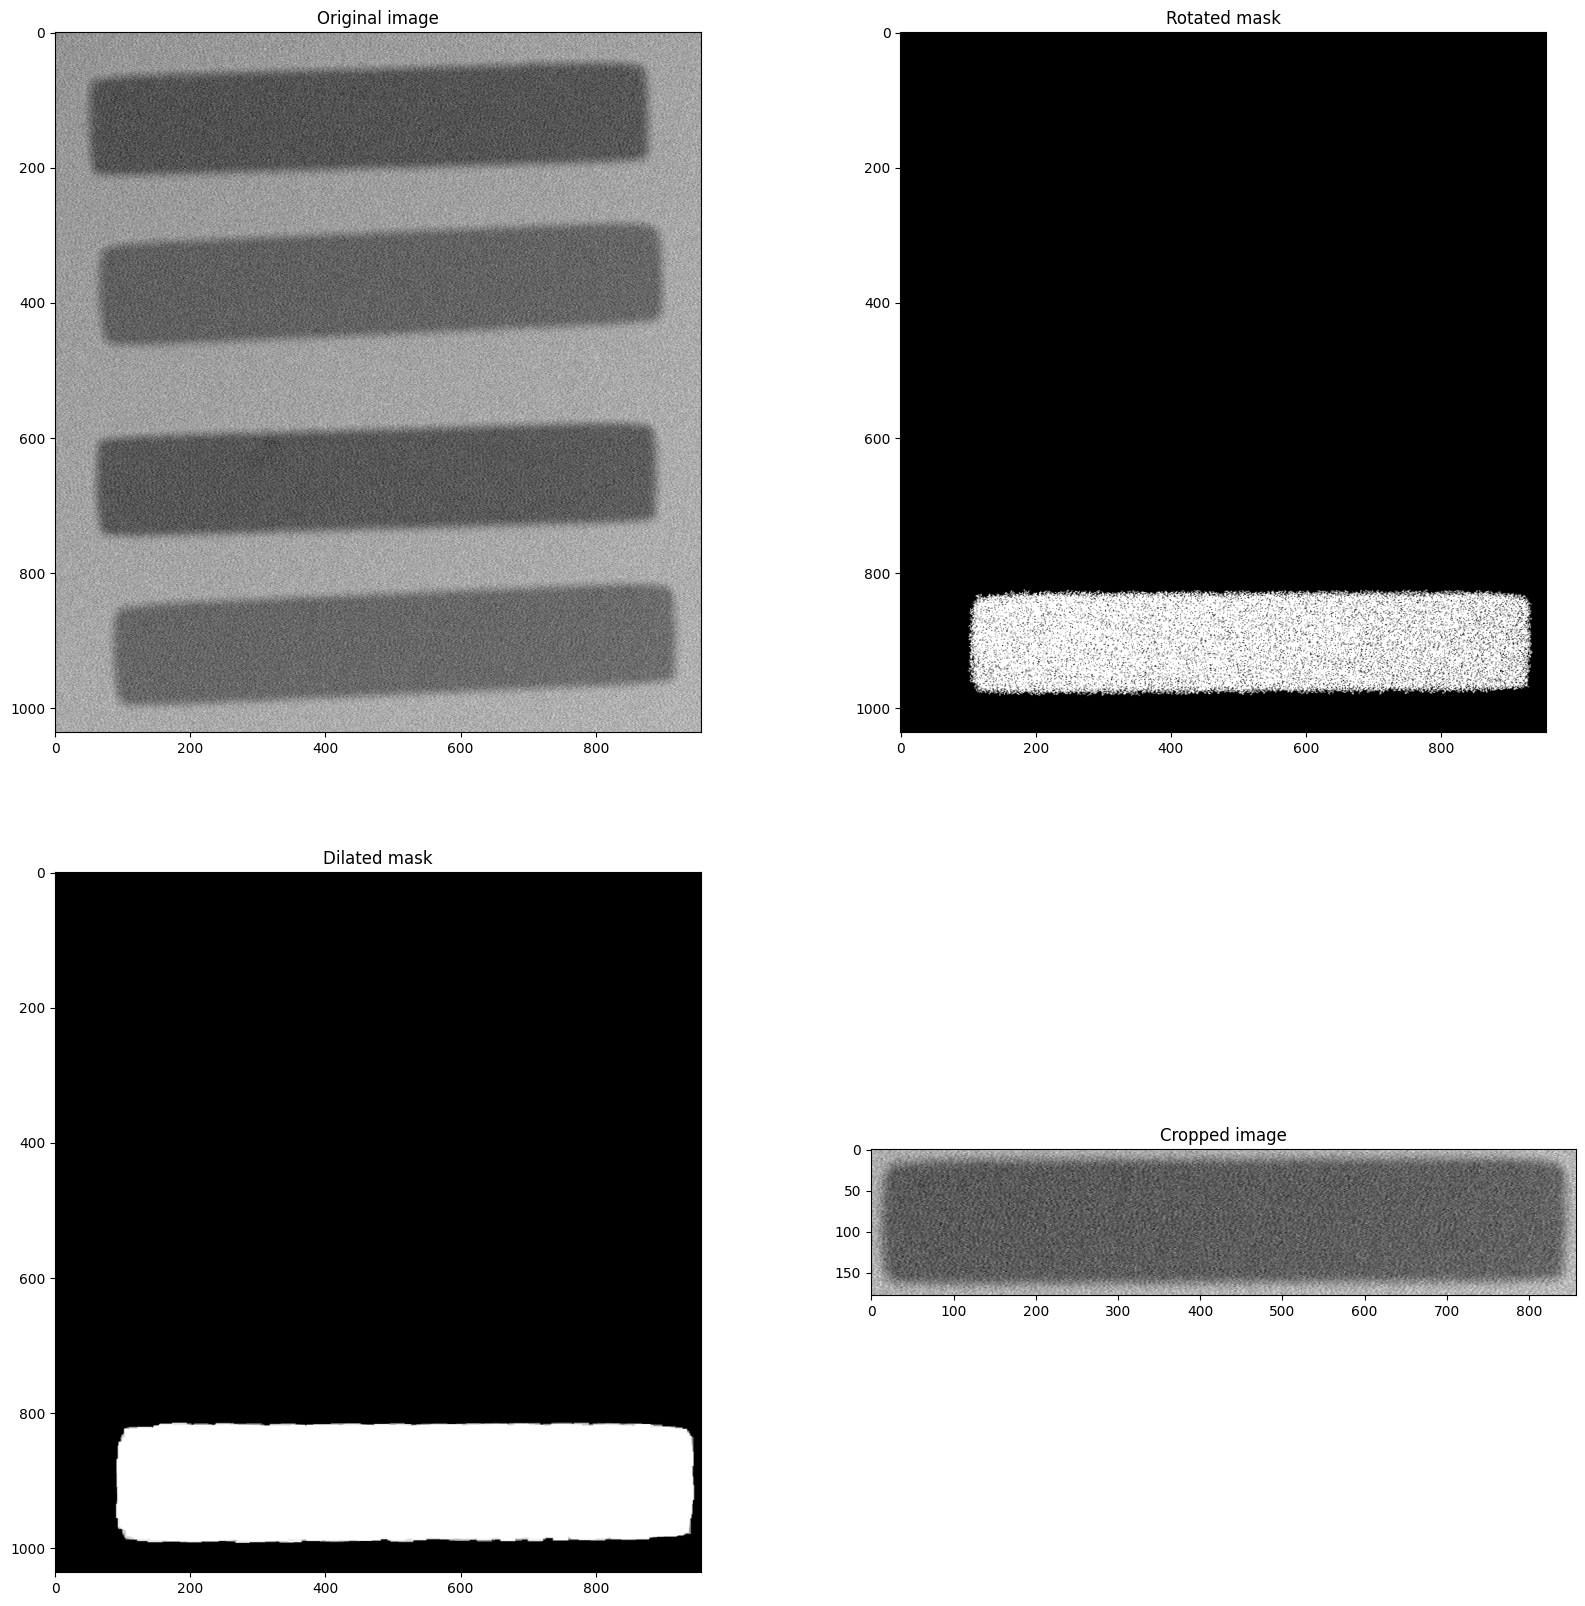

In [13]:
# Get an image for each object. This new image will be a cropped version of the original image
# The object will also be rotation corrected.
object = [get_object(lines_image_gray, mask, show_steps=SHOW_STEPS) for mask in masks]

Okay, we have the objects each in their own image, what now? Now we can extract the profiles and use these to calculate some parameters for the lines in the objects.

/home/nynra/repos/pytools-lithography/src/pytools_lithography/analysis/analysis.py:291: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_right, cov_right = curve_fit(


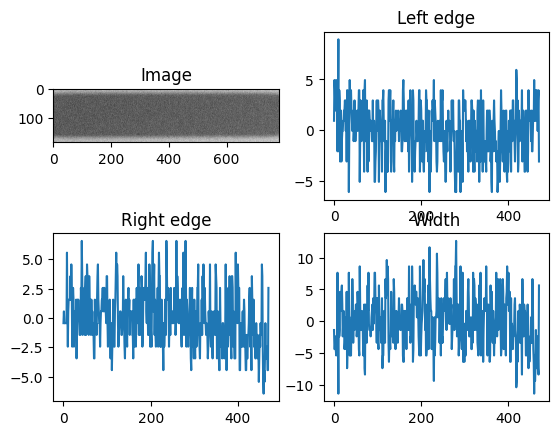

In [14]:
# Extract the first profile
n=1
top, bottom, width = extract_profiles(object[n], show_steps=SHOW_STEPS, accepted_failure=0.5)

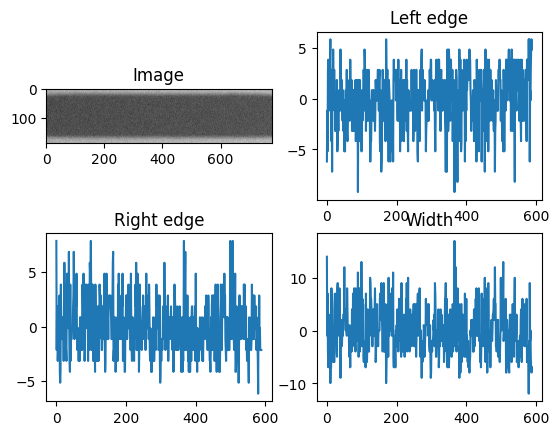

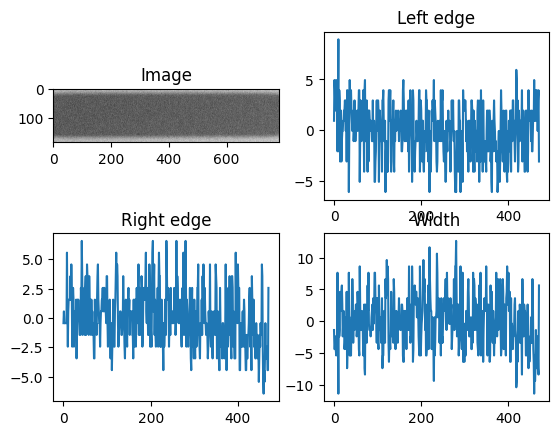

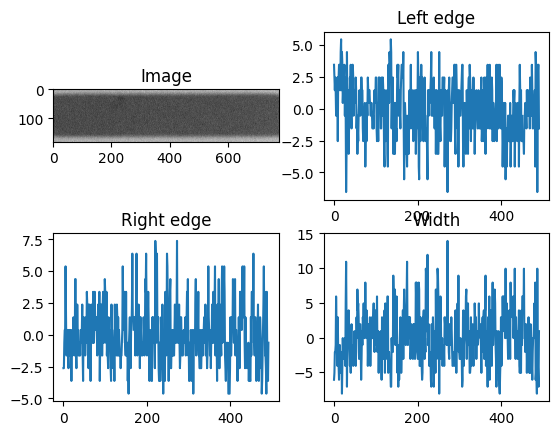

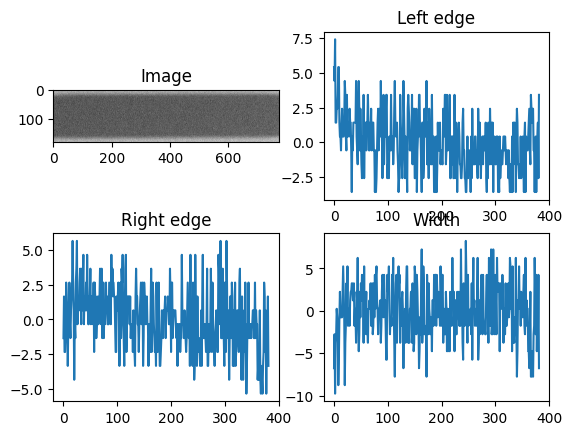

In [15]:
# Extract all the profiles
profiles = {}
i = 0
for obj, angle in zip(object, angles):
    top_edge, bottom_edge, width = extract_profiles(
        obj, accepted_failure=0.80, show_steps=SHOW_STEPS, verbose=False,
    )
    profiles[i] = {
        "top_edge": top_edge,
        "bottom_edge": bottom_edge,
        "width": width,
    }
    i += 1

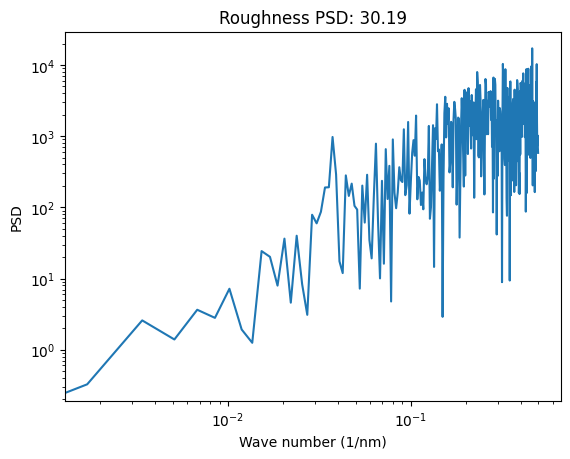

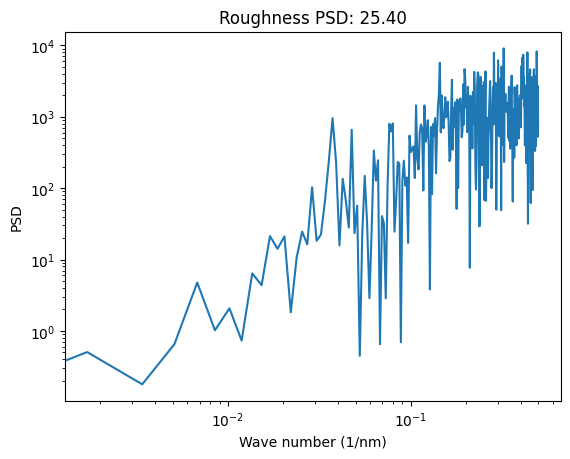

In [16]:
psd, freqs, roughness = calculate_profile_psd(profiles[0]["top_edge"], dx=1, show_steps=SHOW_STEPS)
psd, freqs, roughness = calculate_profile_psd(profiles[0]["bottom_edge"], dx=1, show_steps=SHOW_STEPS)